# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages, Set Directories, Set Seeds

In [3]:
# Import packages
from pathlib import Path
import pandas as pd
import numpy as np
from my_krml_25400603.setup.path import nb_dir
from my_krml_25400603.data.api_utils import coindesk_daily_api_call, coingecko_daily_api_call
from my_krml_25400603.data.subset import timeseries_train_test_split
from my_krml_25400603.data.transform import (create_shift_vars, 
                                             summarize_numerical_transformations, 
                                             detrend_fib_causal, 
                                             TimeToSecondsTransformer,
                                             CyclicalFeatures_CosSin,
                                             reconstruct_fib_causal
                                             )
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from joblib import dump
import shap


In [4]:
# Set notebook name
experiment_name = Path(nb_dir()).stem
print(experiment_name)

36120-25SP-AT3-25400603-experiment-19


In [5]:
# Set parent as directory
nb_path = Path(nb_dir()).resolve().parents[1]
%cd {nb_path}

/Users/dylan/Desktop/UTS Masters/Y1S2 Advanced Machine Learning Application/Assignment 3/AMLA_AT3_Group13


In [6]:
# Set seeds
random_state_int = 42
random_state_gen = np.random.default_rng(42)

---
## A. Project Description


In [7]:
# <Student to fill this section>
student_name = "Dylan Leong Jun Jie"
student_id = "25400603"

In [8]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [9]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [10]:
# <Student to fill this section>
business_use_case_description = """
The objective of this project is to develop a comprehensive cryptocurrency investment data product. The solution will provide next-day (T + 1) price predictions for four major cryptocurrencies through a FastAPI model service: Bitcoin, Ethereum, XRP, and Solana. Historical data and model predictions will be presented to end users through an interactive Streamlit web application. This experiment notebook develops a Bitcoin prediction model, which forms one component of the overall data product.
"""

In [11]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [12]:
# <Student to fill this section>
business_objectives = """
The accuracy of the model’s predictions will have a significant impact on users of the data product, as it is designed to serve as an informative tool for cryptocurrency forecasting. While the product includes clear disclaimers stating that the data and model outputs do not constitute financial, investment, or trading advice, and should not be solely relied upon for such purposes, users may still consider the predictions when making investment decisions. While not financial advice, accurate predictions could provide information for and support user investment decisions, potentially leading to positive financial outcomes. Conversely, inaccurate predictions could misinform users, resulting in poor investment choices and financial losses. Therefore, maintaining model reliability and clearly communicating its limitations are essential to ethical and responsible deployment of this data product.
"""

In [13]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [14]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The results of this model will be integrated into a data product that displays both historical market information and next-day (T + 1) HIGH price predictions for Bitcoin. The predictions are intended to inform users and investors who engage with the platform, supporting them in making more data-driven investment decisions. The primary users of these predictions are individual investors and traders seeking insight into short-term Bitcoin price movements. Secondary stakeholders include cryptocurrency exchanges and other market participants, as the investment actions of data product users may indirectly influence overall market dynamics and trading outcomes.
"""

In [15]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


#### Load CoinBase CCIX Index Data

In [16]:
# Requesting CoinGecko Data for Bitcoin in USD (available data of past 365 days, executed 22 Oct 2025) 
# Not required as data request is saved and loaded locally. Leaving in quotations for transparency.
"""
cd_api_key = "b7287e06f6493d207bf7fa148bfd7c8e7d33fbb25b71fae09c342752f60ccd56"
cd_query = {'market':'ccix',
            'instrument':'BTC-USD',
            'aggregate':1,
            'fill':'true',
            'apply_mapping':'true',
            'response_format':'JSON',
            'limit':365,
            'groups':"ID,OHLC,OHLC_MESSAGE,MESSAGE,VOLUME",
            'api_key':cd_api_key
            }

cd_df = coindesk_daily_api_call(cd_query)
"""

'\ncd_api_key = "b7287e06f6493d207bf7fa148bfd7c8e7d33fbb25b71fae09c342752f60ccd56"\ncd_query = {\'market\':\'ccix\',\n            \'instrument\':\'BTC-USD\',\n            \'aggregate\':1,\n            \'fill\':\'true\',\n            \'apply_mapping\':\'true\',\n            \'response_format\':\'JSON\',\n            \'limit\':365,\n            \'groups\':"ID,OHLC,OHLC_MESSAGE,MESSAGE,VOLUME",\n            \'api_key\':cd_api_key\n            }\n\ncd_df = coindesk_daily_api_call(cd_query)\n'

In [17]:
# Save CoinDesk data
# Not required as data request is saved and loaded locally. Leaving in quotations for transparency.
"""
cd_df.to_pickle('data/CoinDesk_BTC_1year_22102025.pkl')
"""

"\ncd_df.to_pickle('data/CoinDesk_BTC_1year_22102025.pkl')\n"

In [18]:
# Load CoinDesk data
cd_df = pd.read_pickle('data/CoinDesk_BTC_1year_22102025.pkl')

In [19]:
# Preview data
cd_df.head(5)

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,LOW_MESSAGE_VALUE,LOW_MESSAGE_TIMESTAMP,LAST_MESSAGE_VALUE,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME
0,DAY,1729555200,247,ccix,BTC-USD,67358.142469,67800.615743,66540.698523,67390.317578,1729555200,1729641599,67358.142469,67800.615743,1729637809,66540.698523,1729557196,67390.317578,860214,32484.740691,2.184453e+09
1,DAY,1729641600,247,ccix,BTC-USD,67390.317578,67436.285581,65171.544713,66612.967584,1729641600,1729727999,67390.314623,67436.285581,1729641609,65171.544713,1729707629,66612.967584,894130,32488.791043,2.154644e+09
2,DAY,1729728000,247,ccix,BTC-USD,66612.967584,68812.400410,66456.697999,68163.562823,1729728000,1729814399,66612.967584,68812.400410,1729805042,66456.697999,1729729366,68163.562823,946264,31715.508379,2.144280e+09
3,DAY,1729814400,247,ccix,BTC-USD,68163.562823,68745.568467,65510.534994,66577.773234,1729814400,1729900799,68163.562823,68745.568467,1729866690,65510.534994,1729898666,66577.773234,1203975,43824.413398,2.952725e+09
4,DAY,1729900800,247,ccix,BTC-USD,66577.773234,67366.459800,66343.249425,67014.719418,1729900800,1729987199,66577.773234,67366.459800,1729974629,66343.249425,1729908714,67014.719418,517465,14159.114093,9.464474e+08


In [20]:
# Dataset summary information
cd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UNIT                     365 non-null    object 
 1   TIMESTAMP                365 non-null    int64  
 2   TYPE                     365 non-null    object 
 3   MARKET                   365 non-null    object 
 4   INSTRUMENT               365 non-null    object 
 5   OPEN                     365 non-null    float64
 6   HIGH                     365 non-null    float64
 7   LOW                      365 non-null    float64
 8   CLOSE                    365 non-null    float64
 9   FIRST_MESSAGE_TIMESTAMP  365 non-null    int64  
 10  LAST_MESSAGE_TIMESTAMP   365 non-null    int64  
 11  FIRST_MESSAGE_VALUE      365 non-null    float64
 12  HIGH_MESSAGE_VALUE       365 non-null    float64
 13  HIGH_MESSAGE_TIMESTAMP   365 non-null    int64  
 14  LOW_MESSAGE_VALUE        3

In [21]:
# Printing missing values to check data quality
pd.options.display.max_rows = 30

na = cd_df.isna().sum()
print(f"Dataset NA values:\n{na}")


Dataset NA values:
UNIT                       0
TIMESTAMP                  0
TYPE                       0
MARKET                     0
INSTRUMENT                 0
OPEN                       0
HIGH                       0
LOW                        0
CLOSE                      0
FIRST_MESSAGE_TIMESTAMP    0
LAST_MESSAGE_TIMESTAMP     0
FIRST_MESSAGE_VALUE        0
HIGH_MESSAGE_VALUE         0
HIGH_MESSAGE_TIMESTAMP     0
LOW_MESSAGE_VALUE          0
LOW_MESSAGE_TIMESTAMP      0
LAST_MESSAGE_VALUE         0
TOTAL_INDEX_UPDATES        0
VOLUME                     0
QUOTE_VOLUME               0
dtype: int64


In [22]:
# Checking duplicates
dupes = cd_df.duplicated().sum()
print(f'There are {dupes} duplicates within the dataset.\n')

There are 0 duplicates within the dataset.



#### Load CoinGecko Market Cap Data

In [23]:
# Requesting CoinGecko Data for Bitcoin in USD (available data of past 365 days, executed 22 Oct 2025).
# Not required as data request is saved and loaded locally. Leaving in quotations for transparency.
"""
cg_api_key = "CG-MMAvECJBw3zkn4hHFaZTHe73"
cg_query = {'vs_currency':'usd',
            'days':365,
            'interval':'daily',
            'api_key':cg_api_key
            }

cg_df_prices, cg_df_mktcap, cg_df_volumes = coingecko_daily_api_call(cg_query)
"""

'\ncg_api_key = "CG-MMAvECJBw3zkn4hHFaZTHe73"\ncg_query = {\'vs_currency\':\'usd\',\n            \'days\':365,\n            \'interval\':\'daily\',\n            \'api_key\':cg_api_key\n            }\n\ncg_df_prices, cg_df_mktcap, cg_df_volumes = coingecko_daily_api_call(cg_query)\n'

In [24]:
# Save CoinGecko data
# Not required as data request is saved and loaded locally. Leaving in quotations for transparency.
"""
cg_df_prices.to_pickle('data/CoinGecko_BTC_prices_1year_22102025.pkl')
cg_df_mktcap.to_pickle('data/CoinGecko_BTC_mktcap_1year_22102025.pkl')
cg_df_volumes.to_pickle('data/CoinGecko_BTC_volumes_1year_22102025.pkl')
"""

"\ncg_df_prices.to_pickle('data/CoinGecko_BTC_prices_1year_22102025.pkl')\ncg_df_mktcap.to_pickle('data/CoinGecko_BTC_mktcap_1year_22102025.pkl')\ncg_df_volumes.to_pickle('data/CoinGecko_BTC_volumes_1year_22102025.pkl')\n"

In [25]:
# Load CoinDesk market cap data
cg_df_mktcap = pd.read_pickle('data/CoinGecko_BTC_mktcap_1year_22102025.pkl')

In [26]:
# Preview data
cg_df_mktcap.head(5)

,0,1
0,1729555200000,1.332327e+12
1,1729641600000,1.331427e+12
2,1729728000000,1.318285e+12
3,1729814400000,1.347888e+12
4,1729900800000,1.313975e+12


In [27]:
# Dataset summary information
cg_df_mktcap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       366 non-null    int64  
 1   1       366 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.8 KB


In [28]:
# Printing missing values to check data quality
pd.options.display.max_rows = 300

na = cg_df_mktcap.isna().sum()
print(f"Dataset NA values:\n{na}")


Dataset NA values:
0    0
1    0
dtype: int64


In [29]:
# Checking duplicates
dupes = cg_df_mktcap.duplicated().sum()
print(f'There are {dupes} duplicates within the dataset.\n')

There are 0 duplicates within the dataset.



#### Clean & Combine Datasets

In [30]:
# Create column headers for CoinGecko data
cg_df_mktcap.columns = ['timestamp', 'market_cap']

In [31]:
# Cast timestamp variables to datetime: CoinDesk timestamps are in seconds, CoinGecko in milliseconds

# CoinDesk
for dt_col in cd_df.columns[cd_df.columns.str.contains("TIMESTAMP")]:
    cd_df[dt_col] = pd.to_datetime(cd_df[dt_col], unit='s', errors='coerce')
    cd_df[dt_col] = cd_df[dt_col].dt.tz_localize(None)  # ensure naive (no tz)

# CoinGecko
cg_df_mktcap['timestamp'] = pd.to_datetime(cg_df_mktcap['timestamp'], unit='ms', errors='coerce')
cg_df_mktcap['timestamp'] = cg_df_mktcap['timestamp'].dt.tz_localize(None)

In [32]:
# Set datetimes as df indices
cd_df.set_index('TIMESTAMP', inplace=True, drop=True)
cg_df_mktcap.set_index('timestamp', inplace=True, drop=True)


In [33]:
# Merge by datetime indices
df = cd_df.merge(cg_df_mktcap, left_index=True, right_index=True, how='left')

In [34]:
# Preview data
df.head(5)

,UNIT,TYPE,MARKET,INSTRUMENT,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,LOW_MESSAGE_VALUE,LOW_MESSAGE_TIMESTAMP,LAST_MESSAGE_VALUE,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,market_cap
TIMESTAMP,,,,,,,,,,,,,,,,,,,,
2024-10-22,DAY,247,ccix,BTC-USD,67358.142469,67800.615743,66540.698523,67390.317578,2024-10-22,2024-10-22 23:59:59,67358.142469,67800.615743,2024-10-22 22:56:49,66540.698523,2024-10-22 00:33:16,67390.317578,860214,32484.740691,2.184453e+09,1.332327e+12
2024-10-23,DAY,247,ccix,BTC-USD,67390.317578,67436.285581,65171.544713,66612.967584,2024-10-23,2024-10-23 23:59:59,67390.314623,67436.285581,2024-10-23 00:00:09,65171.544713,2024-10-23 18:20:29,66612.967584,894130,32488.791043,2.154644e+09,1.331427e+12
2024-10-24,DAY,247,ccix,BTC-USD,66612.967584,68812.400410,66456.697999,68163.562823,2024-10-24,2024-10-24 23:59:59,66612.967584,68812.400410,2024-10-24 21:24:02,66456.697999,2024-10-24 00:22:46,68163.562823,946264,31715.508379,2.144280e+09,1.318285e+12
2024-10-25,DAY,247,ccix,BTC-USD,68163.562823,68745.568467,65510.534994,66577.773234,2024-10-25,2024-10-25 23:59:59,68163.562823,68745.568467,2024-10-25 14:31:30,65510.534994,2024-10-25 23:24:26,66577.773234,1203975,43824.413398,2.952725e+09,1.347888e+12
2024-10-26,DAY,247,ccix,BTC-USD,66577.773234,67366.459800,66343.249425,67014.719418,2024-10-26,2024-10-26 23:59:59,66577.773234,67366.459800,2024-10-26 20:30:29,66343.249425,2024-10-26 02:11:54,67014.719418,517465,14159.114093,9.464474e+08,1.313975e+12


In [35]:
# Dataset summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-10-22 to 2025-10-21
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   UNIT                     365 non-null    object        
 1   TYPE                     365 non-null    object        
 2   MARKET                   365 non-null    object        
 3   INSTRUMENT               365 non-null    object        
 4   OPEN                     365 non-null    float64       
 5   HIGH                     365 non-null    float64       
 6   LOW                      365 non-null    float64       
 7   CLOSE                    365 non-null    float64       
 8   FIRST_MESSAGE_TIMESTAMP  365 non-null    datetime64[ns]
 9   LAST_MESSAGE_TIMESTAMP   365 non-null    datetime64[ns]
 10  FIRST_MESSAGE_VALUE      365 non-null    float64       
 11  HIGH_MESSAGE_VALUE       365 non-null    float64       
 12  HIGH_MESSAGE_TIME

In [36]:
# Printing missing values to check data quality
pd.options.display.max_rows = 300

na = df.isna().sum()
print(f"Dataset NA values:\n{na}")


Dataset NA values:
UNIT                       0
TYPE                       0
MARKET                     0
INSTRUMENT                 0
OPEN                       0
HIGH                       0
LOW                        0
CLOSE                      0
FIRST_MESSAGE_TIMESTAMP    0
LAST_MESSAGE_TIMESTAMP     0
FIRST_MESSAGE_VALUE        0
HIGH_MESSAGE_VALUE         0
HIGH_MESSAGE_TIMESTAMP     0
LOW_MESSAGE_VALUE          0
LOW_MESSAGE_TIMESTAMP      0
LAST_MESSAGE_VALUE         0
TOTAL_INDEX_UPDATES        0
VOLUME                     0
QUOTE_VOLUME               0
market_cap                 0
dtype: int64


In [37]:
# Checking duplicates
dupes = df.duplicated().sum()
print(f'There are {dupes} duplicates within the dataset.\n')

There are 0 duplicates within the dataset.



### C.2 Define Target variable

In [38]:
# <Student to fill this section>
target_definition_explanations = """
Although the intended business target is the next-day (T + 1) HIGH price, the model uses the two-day ahead (T + 2) HIGH price as the operational target variable. This adjustment is necessary because the HIGH price for a given day is only known after the trading day concludes. For example, the HIGH price for October 30th becomes available only on October 31st. Therefore, when generating a next-day prediction for October 31st, the most recent complete HIGH data corresponds to October 29th. By using this target, the model remains causally valid and operationally realistic, ensuring that predictions are based only on data that would have been available at the time of inference.
"""

In [39]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [40]:
# Create target 'precipitation_fall_sumT+1toT+3' for regression model, precipitation within the next 3 days in mm
target_shift = -2
target_var = 'HIGH_T+2'
df[target_var] = (df['HIGH'].shift(periods=target_shift, freq='D'))

### C.4 Split Dataset

In [41]:
# Split dataset
X_train, y_train, X_val, y_val, X_test, y_test = timeseries_train_test_split(df, target_var, train_split=0.6, val_split=0.2)

In [42]:
# <Student to fill this section>
data_splitting_explanations = """
For time series modeling, we adopt a chronological data splitting strategy that respects temporal order to prevent lookahead bias. The dataset is divided sequentially into training, validation, and test subsets, maintaining the natural progression of time. Specifically, 60% of the earliest observations are used for model training, 20% for validation and hyperparameter tuning, and the remaining 20% for final out-of-sample testing. This approach ensures that all model evaluation simulates a realistic forecasting scenario, where future values are never used to inform past predictions. Unlike random splits commonly used in cross-sectional datasets, time-based splits preserve the integrity of temporal dependencies and autocorrelation structures present in the Bitcoin price series.
"""

In [43]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### C.5 Explore Target variable

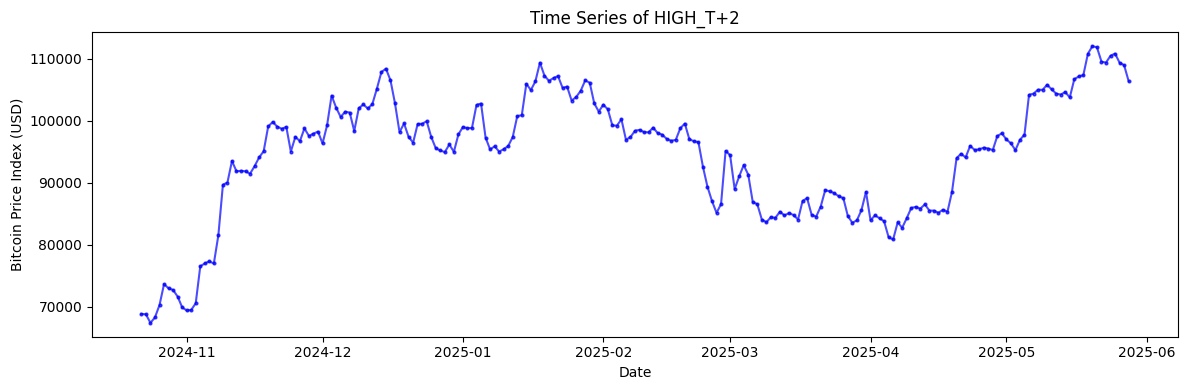

In [44]:
# Plot target variable across time index
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(y_train.index, y_train, color='blue', marker='o', markersize=2, alpha=0.7)
ax.set_title(f'Time Series of {target_var}')
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price Index (USD)')
ax.grid(False)

plt.tight_layout()

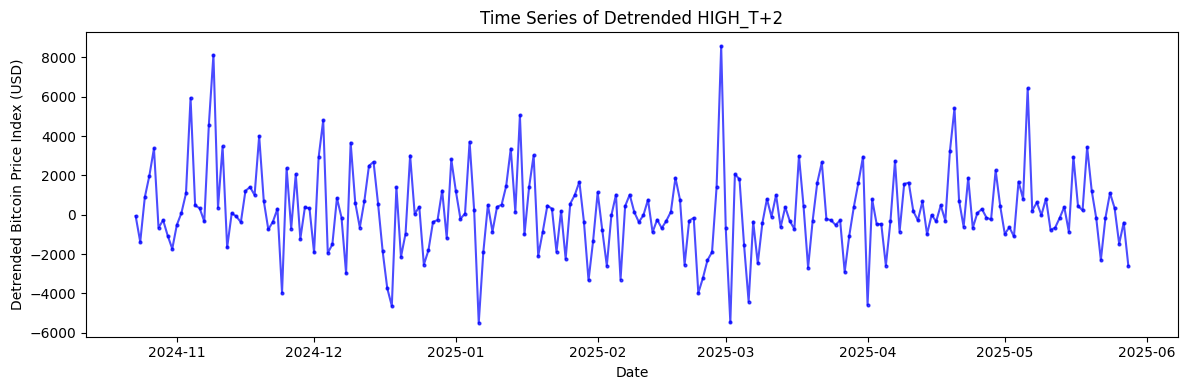

In [ ]:
# Plot detrended target variable across time index 
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(y_train.index, y_train.diff(2), color='blue', marker='o', markersize=2, alpha=0.7)
ax.set_title(f'Time Series of Detrended {target_var}')
ax.set_xlabel('Date')
ax.set_ylabel('Detrended Bitcoin Price Index (USD)')
ax.grid(False)

plt.tight_layout()

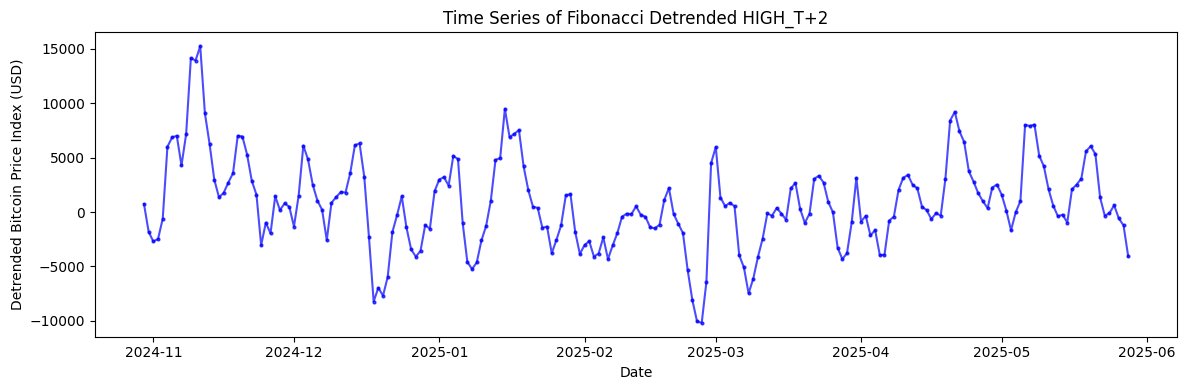

In [ ]:
# Plot detrended target variable across time index 
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(y_train.index[8:], detrend_fib_causal(y_train, y_lag=2, n=8)[8:], color='blue', marker='o', markersize=2, alpha=0.7)
ax.set_title(f'Time Series of Fibonacci Detrended {target_var}')
ax.set_xlabel('Date')
ax.set_ylabel('Detrended Bitcoin Price Index (USD)')
ax.grid(False)

plt.tight_layout()

In [47]:
# <Student to fill this section>
target_distribution_explanations = """
Plotting the HIGH (day + 2) target variable across time from 30 October 2024 to 28 May 2025, we observe relatively smooth volatility overall, with no extended periods of extreme fluctuations. However, there are distinct phases where prices shift to new, higher levels that persist over time. For instance, the series spikes +16.53% over two days—from 7 November 2024 (HIGH (day + 2) = USD 76,929.29) to 9 November 2024 (HIGH (day + 2) = USD 89,644.70). Thereafter, it stabilizes around that range, remaining above USD 90,000 until a major drop between 24–27 February 2025, which briefly reverts before falling again on 6 March 2025, establishing a new level around USD 85,000. Similar upward shifts occur on 19–20 April 2025, 6 May 2025, and 26 May 2025. While this pattern suggests noticeable structural breaks, modeling the raw series directly may not effectively capture short-term, day-to-day dynamics within each regime. To address this, we also plot a T−1 detrend of the target variable, along with a Fibonacci causal lookback using a window size of 8. The T−1 detrend exhibits high volatility, as is typical of detrended data. In contrast, the Fibonacci causal detrend produces a smoother series that may better capture overarching directional trends in daily price movements.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.6 Explore Feature of Interest: Numerical Variabeles

In [49]:
# Subset numerical variables
num_vars = list(X_train.select_dtypes(['float', 'int']).columns)

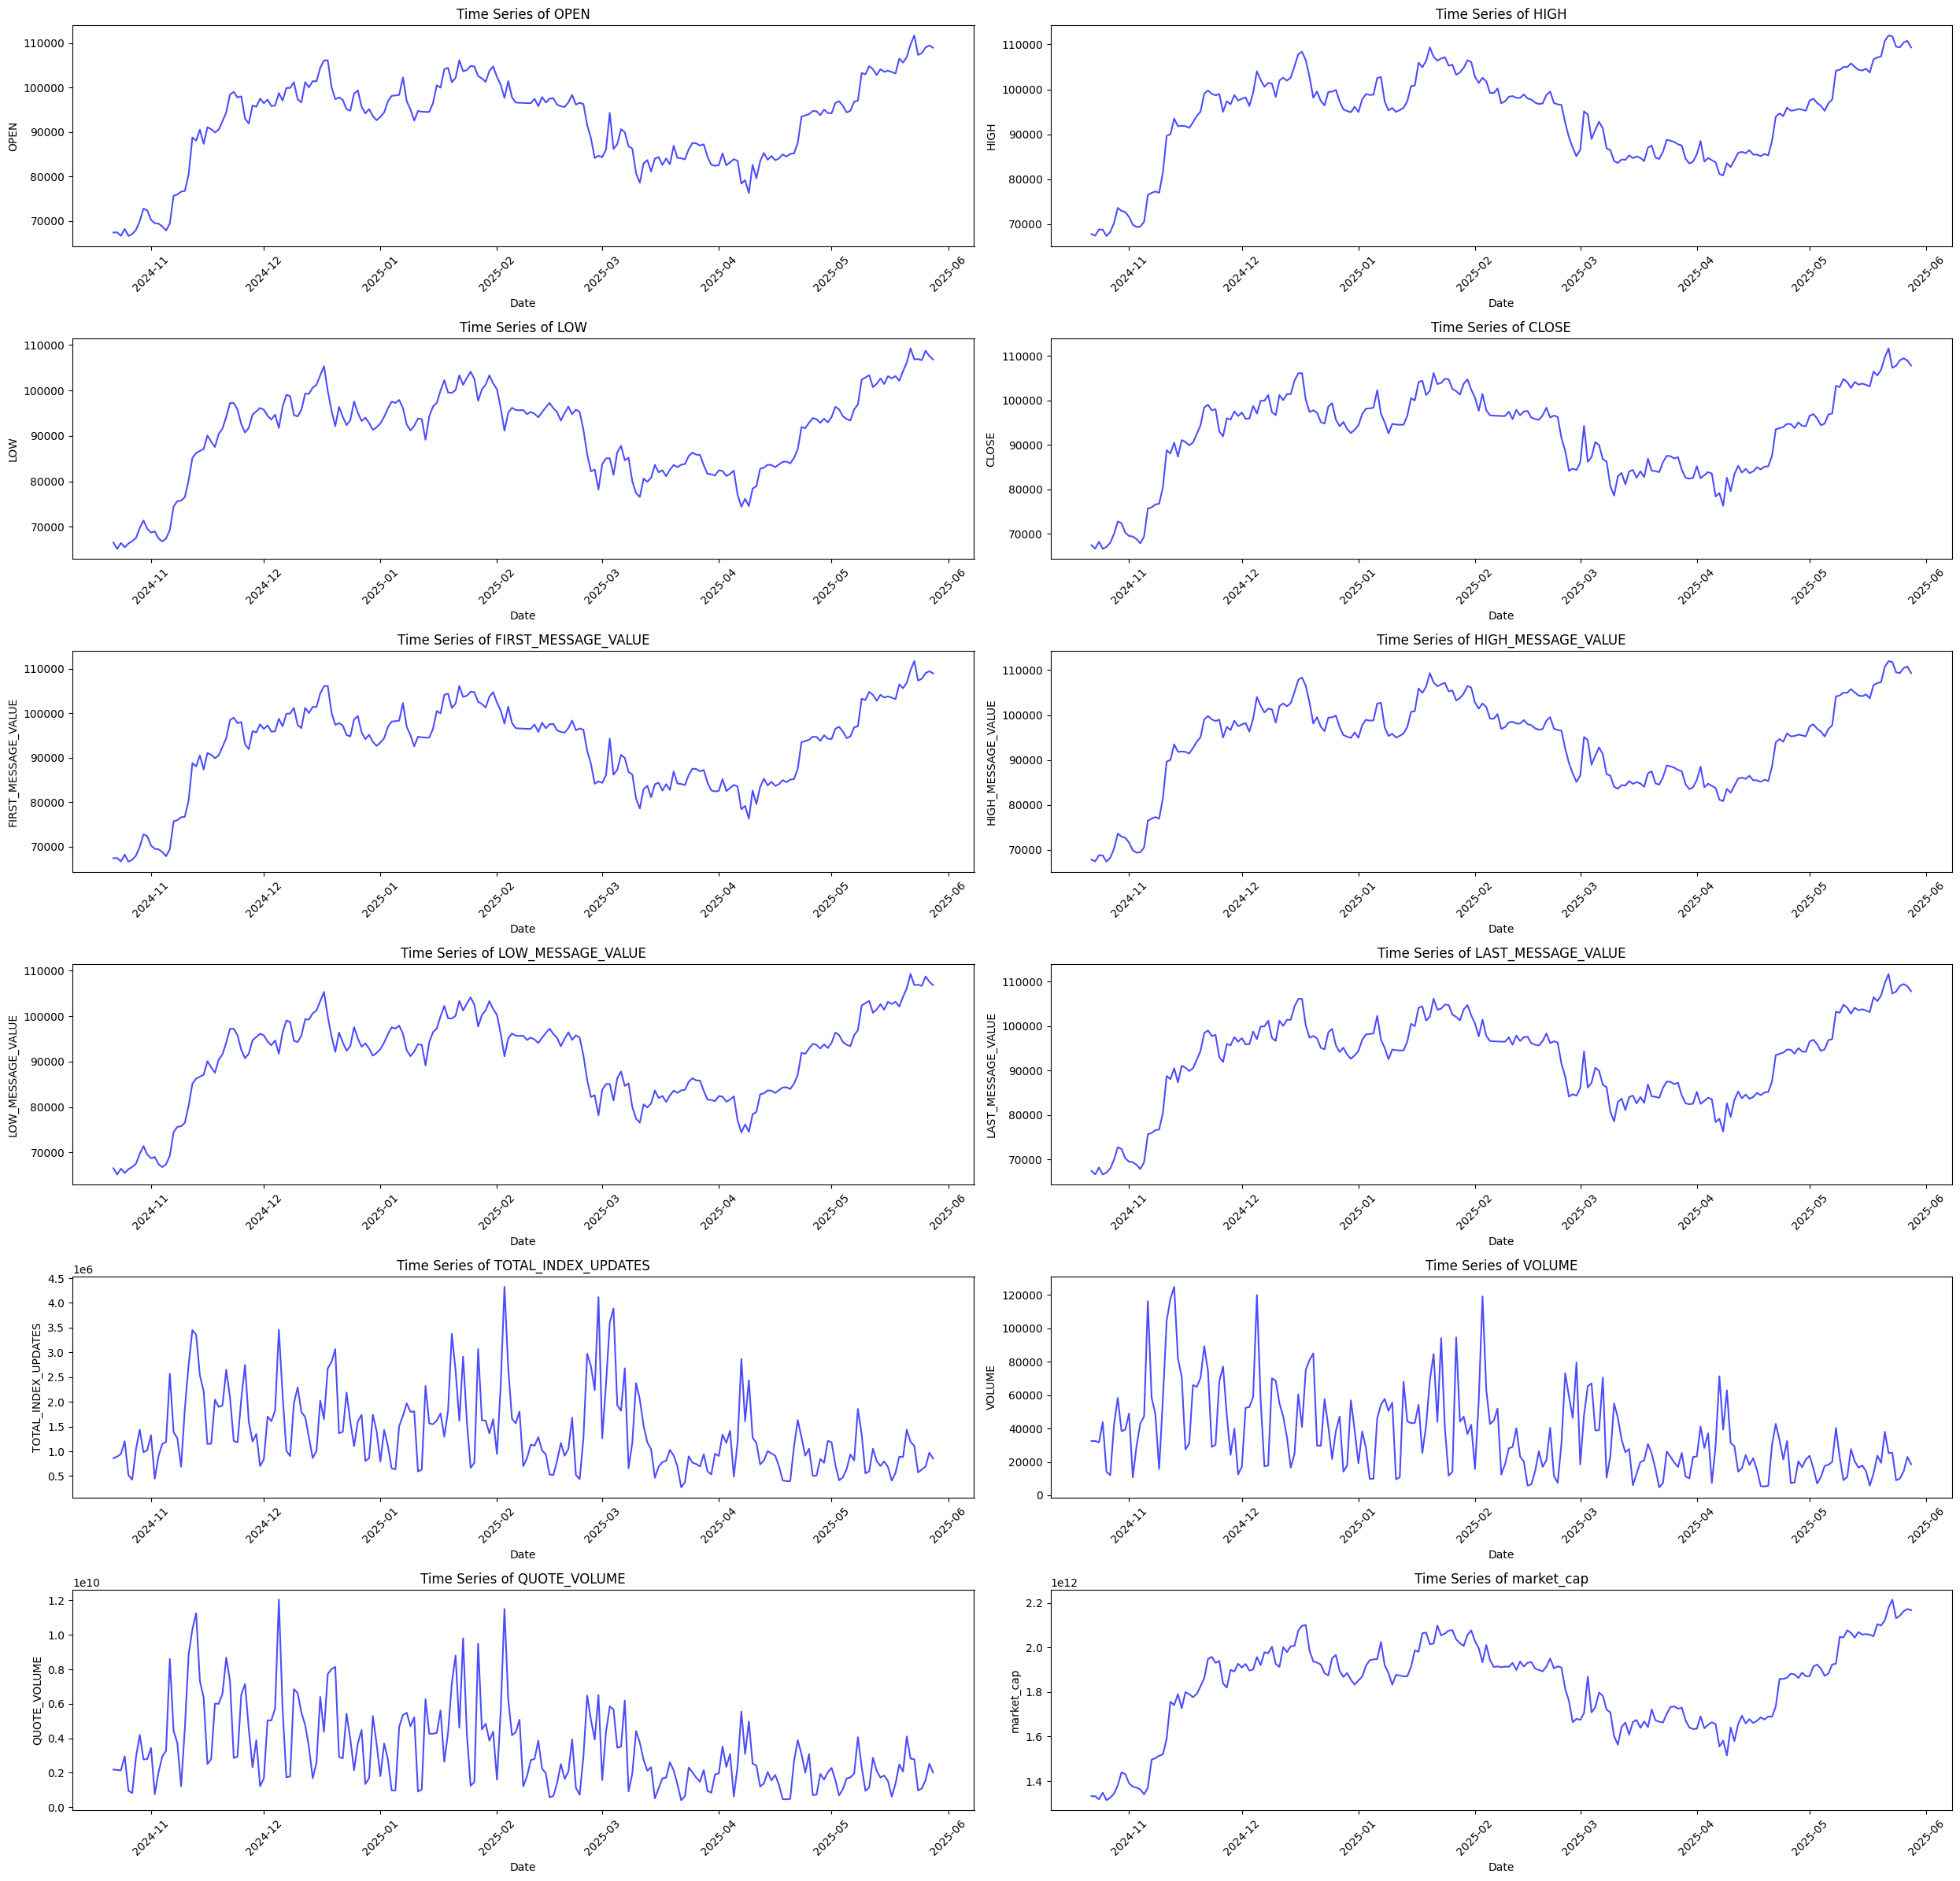

In [50]:
# Plot timeseries of all numerical variables
n_cols = 2
n_rows = (len(num_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
axes = axes.flatten()

for i, num_var in enumerate(num_vars):
    axes[i].plot(X_train.index, X_train[num_var], color='blue', alpha=0.7)
    axes[i].set_title(f'Time Series of {num_var}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(num_var)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


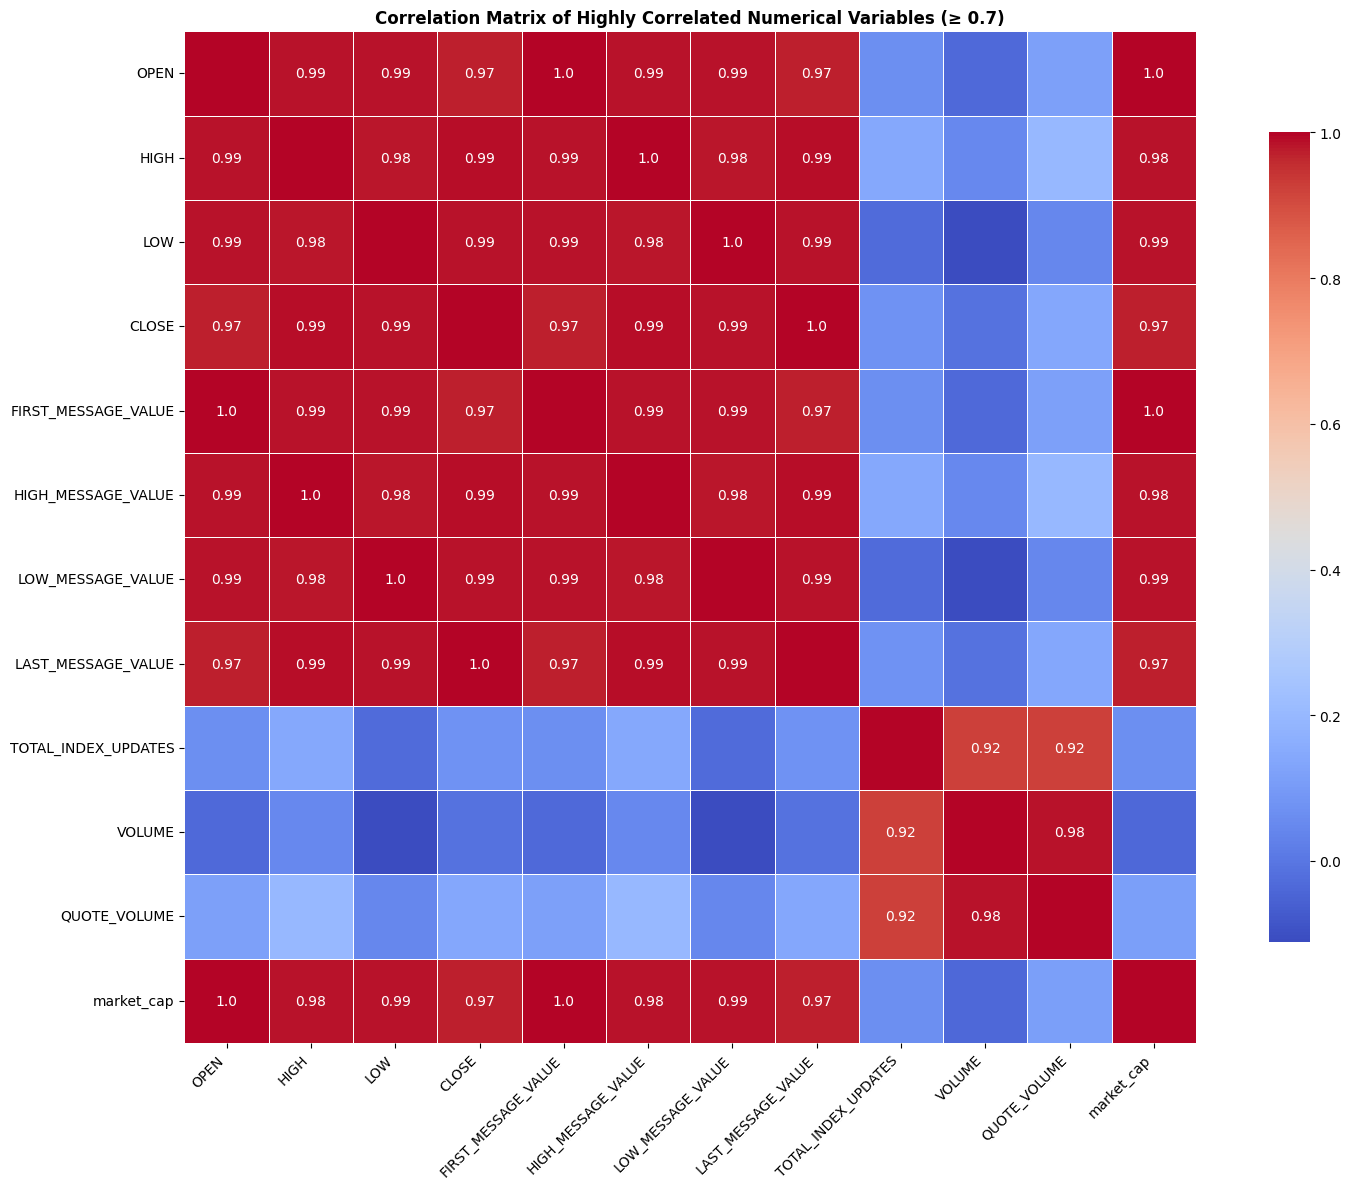

In [ ]:
# Generating correlation plot of numerical variables, that plots only relationships that go above a certain threshold
correlation_mtrx = X_train[num_vars].corr()
threshold = 0.7

mask_offdiag = np.ones(correlation_mtrx.shape, dtype=bool)
np.fill_diagonal(mask_offdiag, False)

features_to_keep = correlation_mtrx.columns[(correlation_mtrx.abs() > threshold).where(mask_offdiag).any()]
subset_corr = correlation_mtrx.loc[features_to_keep, features_to_keep]

annot = subset_corr.round(2).astype(str)
annot = annot.where(subset_corr.abs() >= threshold, other='')
[annot.iat.__setitem__((i, i), '') for i in range(len(annot))]

plt.figure(figsize=(16, 12))
sns.heatmap(subset_corr, cmap='coolwarm', annot=annot, fmt='', linewidths=0.5, linecolor='white', square=True, cbar_kws={'shrink': .8}, annot_kws={"color": "white"} )
plt.title('Correlation Matrix of Highly Correlated Numerical Variables (≥ 0.7)', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [52]:
# <Student to fill this section>
feature_1_insights = """
When plotting all numerical features over time, it is evident that OPEN, HIGH, LOW, CLOSE, FIRST_MESSAGE_VALUE, HIGH_MESSAGE_VALUE, LOW_MESSAGE_VALUE, LAST_MESSAGE_VALUE, and market_cap closely follow the overall trend of the raw HIGH price—and, by extension, the target variable. This observation is supported by the very high positive coefficients in the correlation matrix, indicating strong linear relationships and thus multicollinearity among these variables. Similarly, TOTAL_INDEX_UPDATES, VOLUME, and QUOTE_VOLUME exhibit highly volatile behavior, which is also reflected in their strong positive correlations with one another. Notably, while the volatility across these series is initially high, there is a clear reduction in variability beginning around mid-March 2025, suggesting a possible shift in market dynamics or trading activity during that period. Since multicollinearity amongst these two variable groups may cause issues with convergence and performance of some algorithms, we intentionally select a model that can handle multicollinearity between features as described in later sections.
"""

In [53]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.7 Explore Feature of Interest: Categorical Variables

In [54]:
# Subset categorical variables
cat_vars = list(X_train.select_dtypes('object').columns)

In [55]:
# Number of unique classes
for col in X_train[cat_vars]:
    unique = X_train[col].unique()
    print(f"{len(unique)} unique values of {col}: \n {unique}")
    print("\n")

1 unique values of UNIT: 
 ['DAY']


1 unique values of TYPE: 
 ['247']


1 unique values of MARKET: 
 ['ccix']


1 unique values of INSTRUMENT: 
 ['BTC-USD']




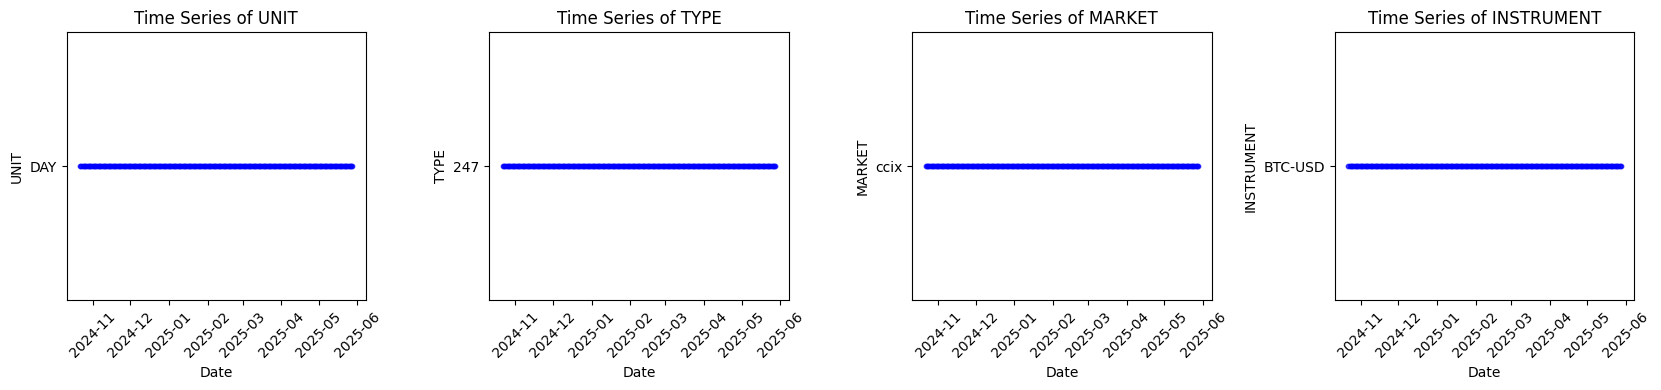

In [56]:
# Plot timeseries of all categorical variables
n_cols = 6
n_rows = (len(cat_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
axes = axes.flatten()

for i, cat_var in enumerate(cat_vars):
    axes[i].scatter(X_train.index, X_train[cat_var], color='blue', alpha=0.7, s=10)
    axes[i].set_title(f'Time Series of {cat_var}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(cat_var)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

In [57]:
# <Student to fill this section>
feature_2_insights = """
All categorical variables in the dataset—UNIT, TYPE, MARKET, and INSTRUMENT—contain only a single unique category each. Given this lack of variability, these variables do not provide any discriminative or predictive value and will therefore be excluded from the modeling process.
"""

In [58]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.8 Explore Feature of Interest: Temporal Variables

In [59]:
# Subset temporal variables
time_vars = ['FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 'HIGH_MESSAGE_TIMESTAMP', 'LOW_MESSAGE_TIMESTAMP']

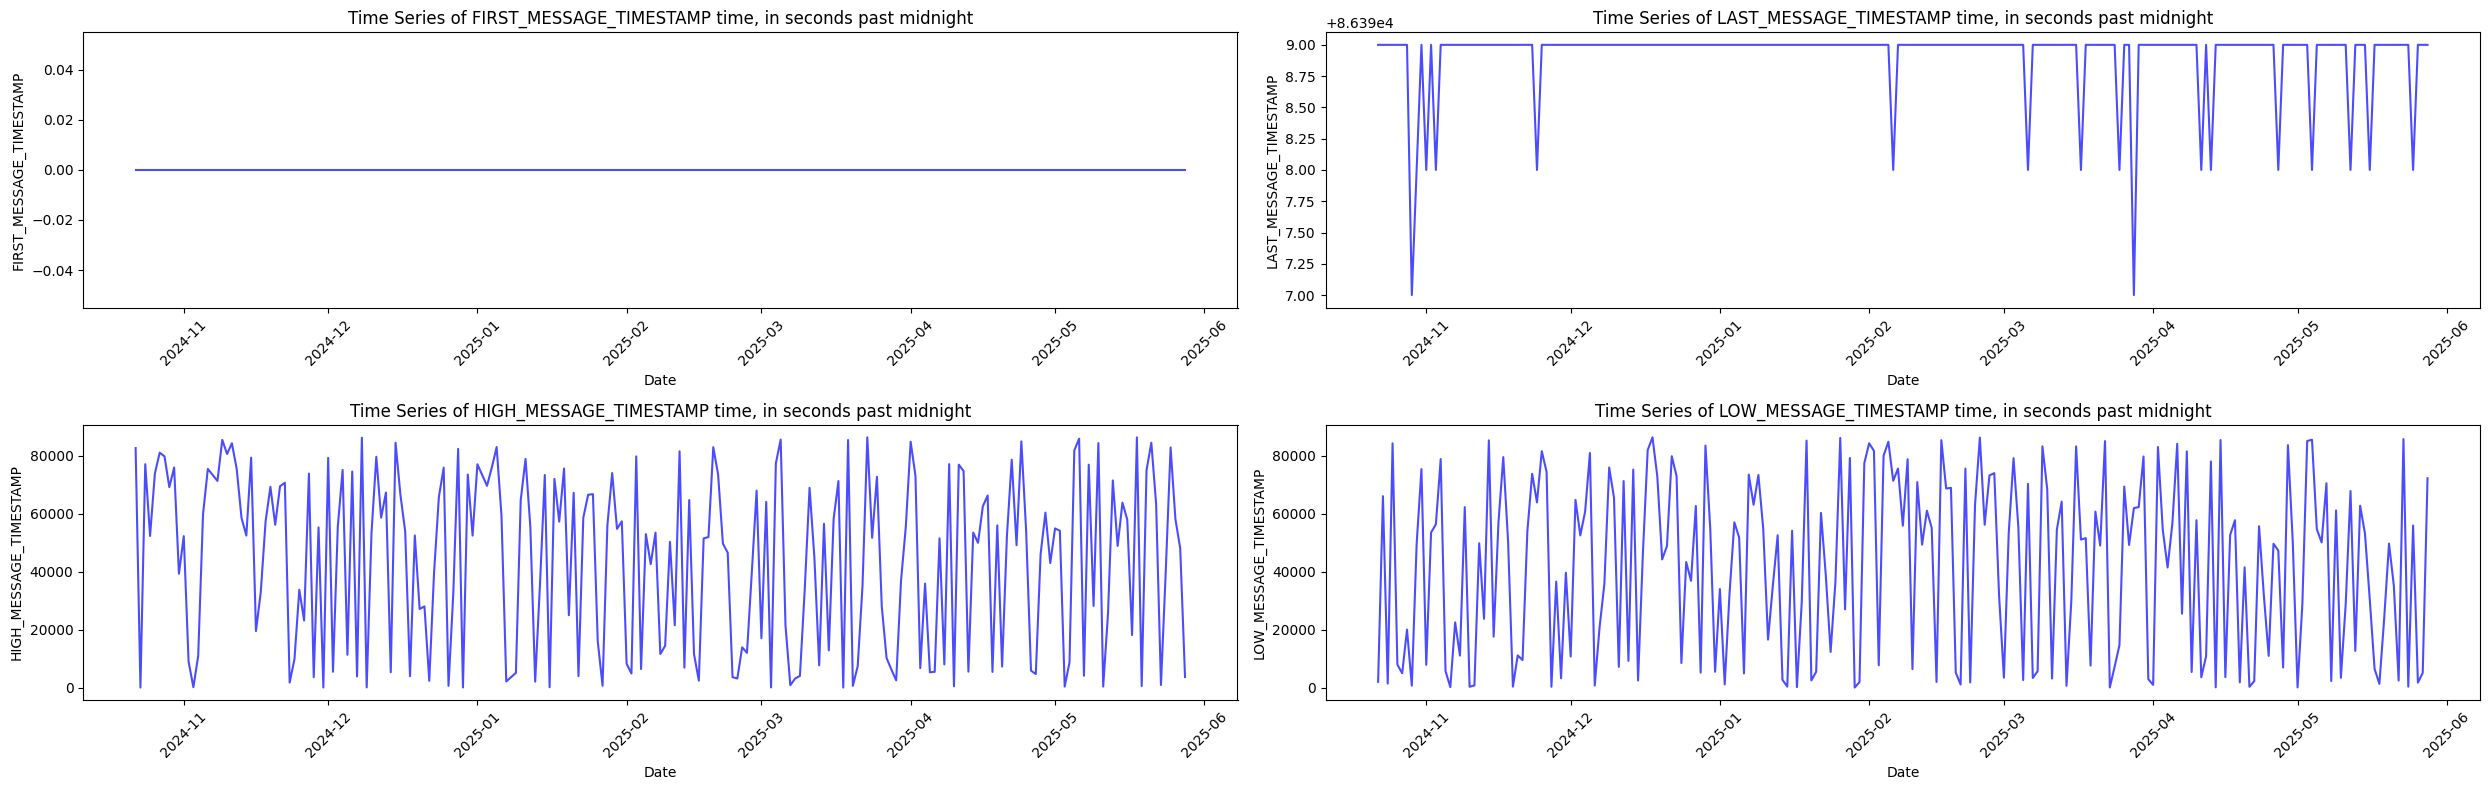

In [60]:
# Plot timeseries of temporal variables
n_cols = 2
n_rows = (len(time_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows))
axes = axes.flatten()

for i, time_vars in enumerate(time_vars):
    axes[i].plot(X_train.index, (X_train[time_vars].dt.hour * 3600 + X_train[time_vars].dt.minute * 60 + X_train[time_vars].dt.second), color='blue', alpha=0.7)
    axes[i].set_title(f'Time Series of {time_vars} time, in seconds past midnight')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(time_vars)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


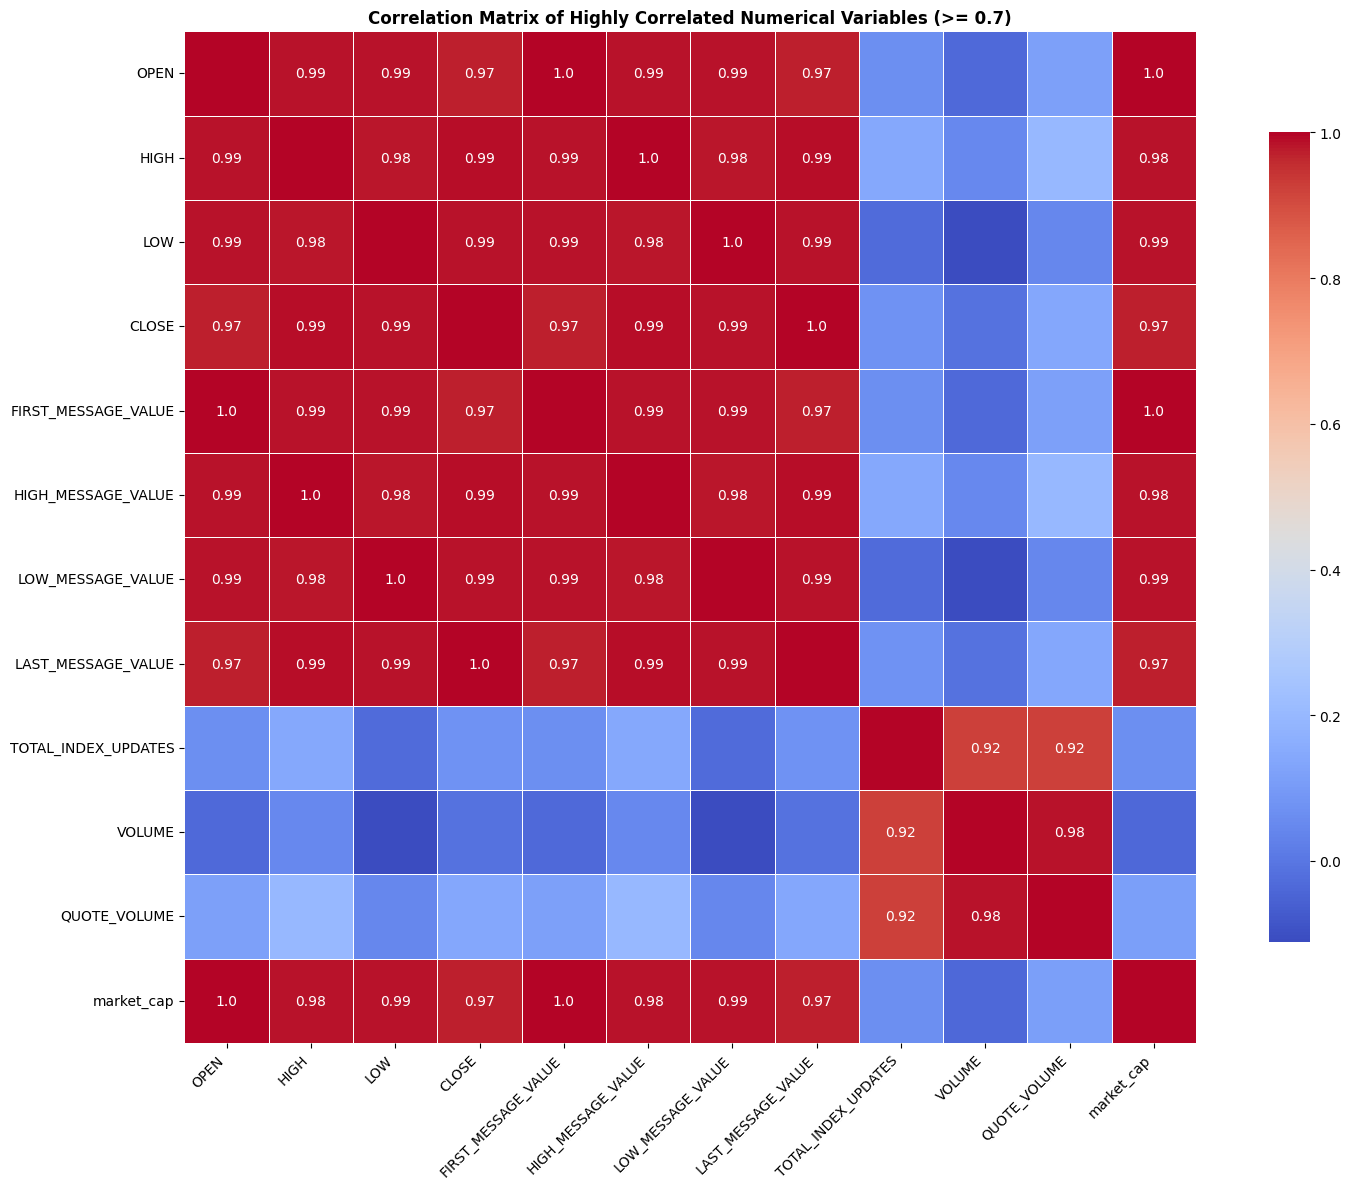

In [61]:
# Generating correlation plot of numerical variables with adjusted time variable, that plots only relationships that go above a certain threshold
first_msg_seconds = (
    X_train['FIRST_MESSAGE_TIMESTAMP'].dt.hour * 3600 +
    X_train['FIRST_MESSAGE_TIMESTAMP'].dt.minute * 60 +
    X_train['FIRST_MESSAGE_TIMESTAMP'].dt.second
)

last_msg_seconds = (
    X_train['LAST_MESSAGE_TIMESTAMP'].dt.hour * 3600 +
    X_train['LAST_MESSAGE_TIMESTAMP'].dt.minute * 60 +
    X_train['LAST_MESSAGE_TIMESTAMP'].dt.second
)

high_msg_seconds = (
    X_train['HIGH_MESSAGE_TIMESTAMP'].dt.hour * 3600 +
    X_train['HIGH_MESSAGE_TIMESTAMP'].dt.minute * 60 +
    X_train['HIGH_MESSAGE_TIMESTAMP'].dt.second
)

low_msg_seconds = (
    X_train['LOW_MESSAGE_TIMESTAMP'].dt.hour * 3600 +
    X_train['LOW_MESSAGE_TIMESTAMP'].dt.minute * 60 +
    X_train['LOW_MESSAGE_TIMESTAMP'].dt.second
)

datetime_seconds = pd.concat([first_msg_seconds, last_msg_seconds, high_msg_seconds, low_msg_seconds], axis=1)

combined_df = pd.concat([X_train[num_vars], datetime_seconds], axis=1)
correlation_mtrx = combined_df.corr()
threshold = 0.7

mask_offdiag = np.ones(correlation_mtrx.shape, dtype=bool)
np.fill_diagonal(mask_offdiag, False)

features_to_keep = correlation_mtrx.columns[(correlation_mtrx.abs() > threshold).where(mask_offdiag).any()]
subset_corr = correlation_mtrx.loc[features_to_keep, features_to_keep]

annot = subset_corr.round(2).astype(str)
annot = annot.where(subset_corr.abs() >= threshold, other='')
[annot.iat.__setitem__((i, i), '') for i in range(len(annot))]

plt.figure(figsize=(16, 12))
sns.heatmap(subset_corr, cmap='coolwarm', annot=annot, fmt='', linewidths=0.5, linecolor='white', square=True, cbar_kws={'shrink': .8}, annot_kws={"color": "white"} )
plt.title('Correlation Matrix of Highly Correlated Numerical Variables (>= 0.7)', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [62]:
# <Student to fill this section>
feature_3_insights = """
To examine the temporal distribution of the time-related variables (FIRST_MESSAGE_TIMESTAMP, LAST_MESSAGE_TIMESTAMP, HIGH_MESSAGE_TIMESTAMP, and LOW_MESSAGE_TIMESTAMP) each timestamp was transformed into seconds after midnight and plotted over time. The analysis shows that FIRST_MESSAGE_TIMESTAMP exhibits little to no temporal variability, indicating messages consistently occur at a similar time each day. LAST_MESSAGE_TIMESTAMP displays relatively stable variability, typically clustering near the maximum seconds in a day, with only occasional days ending earlier. In contrast, HIGH_MESSAGE_TIMESTAMP and LOW_MESSAGE_TIMESTAMP demonstrate substantial temporal volatility, with their occurrence times varying significantly across the observation period. Finally, none of the time variables display strong linear relationships with the other numerical features, suggesting they capture independent temporal behaviour rather than direct price-related dynamics.
"""

In [63]:
# Do not modify this code
print_tile(size="h3", key='feature_3_insights', value=feature_3_insights)

---
## D. Feature Selection


### D.1 Approach: Maximum Information Model


In [64]:
# <Student to fill this section>
feature_selection_1_insights = """
We select all available predictors for comprehensive strategy that maximizes the amount of information from our dataset. This approach is feasible given the chosen algorithm, the CatBoost Regressor, which is well-suited for complex tabular data. CatBoost can natively handle multicollinearity, non-linear relationships, internal regularization, and missing values, making it particularly appropriate for this use case. The dataset contains several highly correlated numerical features, and CatBoost’s built-in regularization mechanisms, including parameters such as bagging temperature, leaf penalties, and random split scoring strength, enable the model to effectively identify and prioritize the most influential predictors while mitigating overfitting risks.
"""

In [65]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Final Selection of Features

In [66]:
# <Student to fill this section>
features_list = list(set(X_train.columns) - set(['UNIT','TYPE','MARKET','INSTRUMENT']))

selected_num_vars = [
    'OPEN',
    'HIGH',
    'LOW',
    'CLOSE',
    'FIRST_MESSAGE_VALUE',
    'HIGH_MESSAGE_VALUE',
    'LOW_MESSAGE_VALUE',
    'LAST_MESSAGE_VALUE',
    'TOTAL_INDEX_UPDATES',
    'VOLUME',
    'QUOTE_VOLUME',
    'market_cap'
    ]

selected_time_vars = [
    'FIRST_MESSAGE_TIMESTAMP',
    'LAST_MESSAGE_TIMESTAMP',
    'HIGH_MESSAGE_TIMESTAMP',
    'LOW_MESSAGE_TIMESTAMP'
]

In [67]:
# <Student to fill this section>
feature_selection_explanations = """

The final set of selected features contain numerical variables related to Bitcoin’s daily OPEN, HIGH, LOW, and CLOSE prices. It also includes the FIRST, HIGH, LOW, and LAST  message values, along with their corresponding timestamps. In addition, several features describing market activity are selected, such as total index updates, trading volume, quote volume, and overall market capitalization. Together, these variables capture both price dynamics and market behaviour, providing a comprehensive foundation for predictive modelling.

"""

In [68]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Engineering Pre-Scaling and Standardization: Engineer Indicators From Raw Features

In [69]:
# Testing engineered features
df_list = [X_train, X_val, X_test]

for df in df_list:
    # --- Price-based features ---
    df['interval_volatility'] = df['HIGH'] - df['LOW']                           # volatility during interval
    df['net_price_change'] = df['CLOSE'] - df['OPEN']                            # net price change
    df['normalized_return'] = df['CLOSE'] / df['OPEN'].replace(0, np.nan)        # relative return
    df['normalized_volatility'] = df['HIGH'] / df['LOW'].replace(0, np.nan)      # relative volatility

    # --- Price momentum / pressure ---
    df['upper_pressure'] = df['HIGH'] - df['CLOSE']                              # distance from high
    df['lower_pressure'] = df['CLOSE'] - df['LOW']                               # distance from low

    # --- Message-derived features ---
    df['message_volatility'] = df['HIGH_MESSAGE_VALUE'] - df['LOW_MESSAGE_VALUE']         # message volatility
    df['message_trend'] = df['LAST_MESSAGE_VALUE'] - df['FIRST_MESSAGE_VALUE']            # message trend

    # # message timestamps to seconds since midnight, required calculation here for creation of other features
    for col in ['FIRST_MESSAGE_TIMESTAMP', 
                'LAST_MESSAGE_TIMESTAMP', 
                'HIGH_MESSAGE_TIMESTAMP', 
                'LOW_MESSAGE_TIMESTAMP']:
        df[col] = (
            df[col].dt.hour * 3600 +
            df[col].dt.minute * 60 +
            df[col].dt.second
        )

    # message activity
    df['message_activity_duration'] = df['LAST_MESSAGE_TIMESTAMP'] - df['FIRST_MESSAGE_TIMESTAMP']

    # message velocity = (LAST - FIRST) / interval seconds
    df['message_velocity'] = np.where(
        df['message_activity_duration'] != 0,
        (df['LAST_MESSAGE_VALUE'] - df['FIRST_MESSAGE_VALUE']) / df['message_activity_duration'],
        np.nan
    )

    # --- Volume / liquidity features ---
    df['avg_trade_price'] = df['VOLUME'] / df['QUOTE_VOLUME'].replace(0, np.nan)          # avg trade price
    df['turnover_ratio'] = df['VOLUME'] / df['market_cap'].replace(0, np.nan)             # activity vs size
    df['market_depth'] = df['market_cap'] / df['VOLUME'].replace(0, np.nan)               # depth proxy
    df['valuation_vs_high'] = df['market_cap'] / df['HIGH'].replace(0, np.nan)            # valuation vs price
    df['message_trading_ratio'] = df['TOTAL_INDEX_UPDATES'] / df['VOLUME'].replace(0, np.nan)    # messages per volume



In [70]:
engineered_cols = [
    'interval_volatility', 'net_price_change', 'normalized_return', 'normalized_volatility',
    'upper_pressure', 'lower_pressure',
    'message_volatility', 'message_trend', 'message_activity_duration', 'message_velocity',
    'avg_trade_price', 'turnover_ratio', 'market_depth', 'valuation_vs_high', 'message_trading_ratio'
]

selected_num_vars = list(set(selected_num_vars) | set(engineered_cols))

In [71]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Before applying feature transformations, several indicators were engineered to capture nuanced aspects of Bitcoin market dynamics. Price-based indicators such as interval volatility, net price change, normalized return, and normalized volatility were calculated to represent short-term price movements and variability. To account for price momentum, upper and lower pressure indicators were created to reflect the distance between closing prices and the daily extremes. Message-based indicators were also developed to capture intra-period messaging behavior, including message volatility derived from high and low message values and message trend derived from first and last message values. Message activity duration and message velocity indicators are created, which capture the timing and rate of message-driven activity throughout the trading day. Finally, volume and liquidity indicators were constructed to represent trading activity and market conditions, including average trade price, turnover ratio, market depth, market valuation normalized by high price, and the ratio of total index updates to volume. Together, these engineered indicators provide a richer feature set that integrates price dynamics, message behavior, and market liquidity signals.
"""

In [72]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation: Transform and Scale Numeric Variables

In [73]:
# Test transformations
summary_df = summarize_numerical_transformations(X_train[selected_num_vars])
summary_df


Yeo-johnson transformation failed for column: message_activity_duration, error: BracketError - The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,feature,method,composite_score,p_value,skew
0,normalized_volatility,box-cox,-0.089320,0.001100,0.142936
1,normalized_return,yeo-johnson,-0.316366,0.002490,0.044718
2,market_depth,yeo-johnson,-0.021610,0.042548,0.027550
3,message_velocity,yeo-johnson,-0.278530,0.008021,0.018617
4,net_price_change,yeo-johnson,-0.279856,0.007774,0.021965
5,message_trend,yeo-johnson,-0.279856,0.007773,0.021966


In [74]:
# Gather feature name lists of transformations to perform
yeo_johnson_vars = summary_df.loc[summary_df['method'] == 'yeo-johnson', 'feature'].tolist()
quantile_vars = summary_df.loc[summary_df['method'] == 'quantile', 'feature'].tolist()



In [75]:
# Create pipeline object for numerical transformation and scaling
num_transformer = Pipeline(
    steps=[
        ('transformers', ColumnTransformer([
            ('yeo', PowerTransformer(method='yeo-johnson'), yeo_johnson_vars),
            ('quant', QuantileTransformer(output_distribution='normal', random_state=random_state_int, subsample=int(1e9)), quantile_vars)
            ],
            remainder='passthrough')
            ),
        ('scaler', StandardScaler())
    ]
)

In [76]:
# <Student to fill this section>
data_cleaning_2_explanations = """
We standardize numerical features to improve model convergence and predictive stability. Each feature is evaluated across multiple normality transformations (log, square root, Box–Cox, Yeo–Johnson, quantile, or none) to identify the transformation that maximizes a composite normality score. This score combines statistical normality (D’Agostino’s K-squared test p-value) with penalties for skewness, kurtosis, and outlier fraction. The selected transformation is applied to each feature before final standardization.
"""

In [77]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation: Transform Temporal Variable

In [78]:
# Create pipeline object for time variable transformation
seconds_after_midnight_period = 86400

time_transformer = Pipeline(
    steps=[
        ('time_in_seconds_transformer', TimeToSecondsTransformer(selected_time_vars)),
        ('sine_cosine_transformer', CyclicalFeatures_CosSin({'FIRST_MESSAGE_TIMESTAMP_seconds': seconds_after_midnight_period,
                                                             'LAST_MESSAGE_TIMESTAMP_seconds':seconds_after_midnight_period,
                                                             'HIGH_MESSAGE_TIMESTAMP_seconds':seconds_after_midnight_period,
                                                             'LOW_MESSAGE_TIMESTAMP_seconds':seconds_after_midnight_period
                                                             })
        )
    ]
)


In [79]:
# <Student to fill this section>
data_cleaning_3_explanations = """
We transform time variables into a numerical format to allow models to train on this critical information. We sine and cosine transform these into cyclical variables to capture the contiguous nature of the lowest and highest values of these features.
"""

In [80]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.4 Create Pipeline

In [81]:
# Create preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num_cols', num_transformer, selected_num_vars),
        ('time_cols', time_transformer, selected_time_vars)
    ]
)

In [82]:
# Set preprocessor to return dataframes
preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('num_cols',
                                 Pipeline(steps=[('transformers',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('yeo',
                                                                                   PowerTransformer(),
                                                                                   ['normalized_return',
                                                                                    'market_depth',
                                                                                    'message_velocity',
                                                                                    'net_price_change',
                                                                                    'message_trend']),
                                                                                  ('quant',
                                                                                   QuantileTransformer(output_distribution='normal',
                                                                                                       random_state=42,
                                                                                                       subsample=1000000000),
                                                                                   [])]...
                                                                                 'LOW_MESSAGE_TIMESTAMP'])),
                                                 ('sine_cosine_transformer',
                                                  CyclicalFeatures_CosSin(cols_periods={'FIRST_MESSAGE_TIMESTAMP_seconds': 86400,
                                                                                        'HIGH_MESSAGE_TIMESTAMP_seconds': 86400,
                                                                                        'LAST_MESSAGE_TIMESTAMP_seconds': 86400,
                                                                                        'LOW_MESSAGE_TIMESTAMP_seconds': 86400}))]),
                                 ['FIRST_MESSAGE_TIMESTAMP',
                                  'LAST_MESSAGE_TIMESTAMP',
                                  'HIGH_MESSAGE_TIMESTAMP',
                                  'LOW_MESSAGE_TIMESTAMP'])])

In [83]:
# Fit pipeline on training data, transform validation and test set
X_train_clean = preprocessor.fit_transform(X_train)
X_val_clean = preprocessor.transform(X_val)
X_test_clean = preprocessor.transform(X_test)

In [84]:
# Save preprocessor 
dump(preprocessor,  f'models/{experiment_name}_preprocessor.joblib')

['models/36120-25SP-AT3-25400603-experiment-19_preprocessor.joblib']

In [85]:
# Clean column names
colnames = [colname.split('__')[-1] for colname in X_train_clean.columns]
X_train_clean.columns = colnames
X_val_clean.columns = colnames
X_test_clean.columns = colnames

In [86]:
# <Student to fill this section>
data_cleaning_4_explanations = """
We create a pipeline to wrap our numerical and time feature transformations, creating and saving a preprocessor object that streamlines data transformation in production.
"""

In [87]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_4_explanations', value=data_cleaning_4_explanations)

---
## F. Feature Engineering

### F.1 New Feature: Shift Predictor Variables


In [88]:
# Create lag of predictor variables
start_lag = 1
end_lag = 7
periods = list(range(start_lag, (end_lag +1 ), 1))
targets = [*X_train_clean.columns]
freq = 'D'

X_train_lags = create_shift_vars(X_train_clean, targets, periods, freq)
X_val_lags = create_shift_vars(X_val_clean, targets, periods, freq)
X_test_lags = create_shift_vars(X_test_clean, targets, periods, freq)


In [89]:
# <Student to fill this section>
feature_engineering_1_explanations = """
Since past values of the predictor variables are likely to contain critical information for future values, we create lags of predictors.
"""

In [90]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature: Shift Target Variable




In [91]:
# Create lag of target variable of one and a half months
start_lag = 2 # start at 2 since information before would not be available in production
end_lag = 8
periods = list(range(start_lag, (end_lag + 1), 1))
targets = y_train.name
freq = 'D'

y_train_lags = pd.DataFrame()
y_val_lags = pd.DataFrame()
y_test_lags = pd.DataFrame()

for period in periods:
    sign = "+" if period < 0 else "-"  # if we use negative period, we are moving future values to today, thus values are T+period
    abs_period = abs(period)
    col_name = f'lag_T{sign}{abs_period}_{freq}_{y_train.name}'
    y_train_lags[col_name] = y_train.shift(periods=period, freq=freq)
    y_val_lags[col_name] = y_val.shift(periods=period, freq=freq)
    y_test_lags[col_name] = y_test.shift(periods=period, freq=freq)


In [92]:
# Left join with predictor splits
X_train_lags = X_train_lags.join(y_train_lags)
X_val_lags = X_val_lags.join(y_val_lags)
X_test_lags = X_test_lags.join(y_test_lags)

In [93]:
# Drop observations with NaN
X_train_lags = X_train_lags.dropna()
X_val_lags = X_val_lags.dropna()
X_test_lags = X_test_lags.dropna()

In [94]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Since past values of the target variable is likely to contain critical information for future values, we create lags of the target.
"""

In [95]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature: Fibonacci Causal Transformed Target Variable




In [96]:
# Fibonacci Causal transform target variable
y_train_fib = detrend_fib_causal(y_train, y_lag=2, n=8)
y_val_fib = detrend_fib_causal(y_val, y_lag=2, n=8)

In [97]:
# <Student to fill this section>
feature_engineering_3_explanations = """
As Fibonacci ratios are often referenced in market trading decisions for identifying price supports and resistance levels, we create a Fibonacci causal lookback that detrends the series over a fixed window (in this case, from T–7 to T–2) using Fibonacci-weighted values. This approach removes the trend component influenced by recent price movements while weighting past observations according to the naturally occurring Fibonacci sequence. Because Fibonacci-based investment strategies are commonly reflected in market behavior, detrending with a Fibonacci-weighted series may help capture these trading dynamics as they are embedded in Bitcoin price movements.
"""

In [98]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_3_explanations', value=feature_engineering_3_explanations)

---
## G. Data Preparation for Modeling

### G.1 Data Transformation: Index Matching for X and y

In [99]:
# To align lengths of predictor and target data structures, we match index
y_train = y_train.loc[X_train_lags.index]
y_val = y_val.loc[X_val_lags.index]
y_train_fib = y_train_fib.loc[X_train_lags.index]
y_val_fib = y_val_fib.loc[X_val_lags.index]
y_test = y_test.loc[X_test_lags.index]

In [100]:
# <Student to fill this section>
data_splitting_explanations = """
To ensure the indices of the predictor and targets are aligned for model training and validation, we match indices.
"""

In [101]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

---
## H. Save Datasets

> Do not change this code

In [102]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'at' is not defined


---
## I. Selection of Performance Metrics



In [103]:
# <Student to fill this section>
performance_metrics_explanations = """
For our regression task, we select Mean Absolute Error (MAE) as the primary evaluation metric due to its direct interpretability and balanced sensitivity to prediction errors. MAE emphasizes average short-term predictive accuracy without disproportionately penalizing extreme deviations, as would occur with Root Mean Squared Error (RMSE). We additionally report RMSE for completeness, Mean Absolute Percentage Error (MAPE) for scale-independent comparison, and R-squared (R²) to quantify the proportion of variance explained by the model.
"""

In [104]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm



In [105]:
# Create objective function for training and CV of model
def objective(params):
    params['iterations'] = int(params['iterations'])
    params['depth'] = int(params['depth'])
    
    model = CatBoostRegressor(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        bagging_temperature=params['bagging_temperature'],
        random_strength=params['random_strength'],
        loss_function='MAE',
        verbose=0,
        random_seed=random_state_int
    )
    
    model.fit(X_train_lags, y_train_fib, eval_set=(X_val_lags, y_val_fib), early_stopping_rounds=50, verbose=False) # log values 
    
    val_preds_fib = model.predict(X_val_lags)  # fib residual values
    val_preds_fib = pd.Series(data=val_preds_fib, index=X_val_lags.index)
    val_preds = reconstruct_fib_causal(val_preds_fib, X_val['HIGH'], y_lag=0, n=8)
    val_preds_clipped = np.clip(val_preds, a_min=0, a_max=None)
    mae = mean_absolute_error(y_val, val_preds_clipped)
    
    return {'loss': mae, 'status': STATUS_OK}

In [106]:
# <Student to fill this section>
algorithm_selection_explanations = """
We select the powerful gradient boosting algorithm CatBoost for our Bitcoin prediction. CatBoost can natively handle multicollinearity, non-linear relationships, internal regularization, and missing values, making it particularly appropriate for this use case given the observed multicollinearity of numerical variables and our feature selection strategy. CatBoost’s built-in regularization mechanisms, including parameters such as bagging temperature, leaf penalties, and random split scoring strength, enable the model to effectively identify and prioritize the most influential predictors while mitigating overfitting risks.
"""

In [107]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters



In [108]:
# Create hyperparameter seach space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.quniform('depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10)),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 1, 20)
}

In [109]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
We tune iterations and depth to control number of trees in each forest and individual tree size for model performance. We adjust learning rate to tune model convergence and performance. We adjust leaf regularization, bagging temperature, and random strength to adjust regularization, mitigating model overfitting and improving generalization.
"""

In [110]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [111]:
# Execute hyperopt search space to find best model
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=random_state_gen
            )

print("Best hyperparameters:", best)

100%|██████████| 50/50 [08:17<00:00,  9.95s/trial, best loss: 1656.042231047974] 
Best hyperparameters: {'bagging_temperature': np.float64(0.7401894148400094), 'depth': np.float64(4.0), 'iterations': np.float64(100.0), 'l2_leaf_reg': np.float64(2.498604814642479), 'learning_rate': np.float64(0.10224695330819393), 'random_strength': np.float64(4.65385901310944)}


### J.4 Model Technical Performance



#### Final Model Performance

In [112]:
# Combine training and validation sets for model training
X_trainval_lags_combined = pd.concat([X_train_lags, X_val_lags])
y_trainval_combined = pd.concat([y_train_fib, y_val_fib]) # fib values 


In [113]:
# Define model using best hyperparameters
best_model = CatBoostRegressor(
        iterations=best['iterations'],
        depth=best['depth'],
        learning_rate=best['learning_rate'],
        l2_leaf_reg=best['l2_leaf_reg'],
        bagging_temperature=best['bagging_temperature'],
        random_strength=best['random_strength'],
        loss_function='MAE',
        verbose=0,
        random_seed=random_state_int
    )


In [114]:
# Fit best model
best_model.fit(X_trainval_lags_combined, y_trainval_combined)


In [115]:
# Generate test predictions
test_preds_fib = best_model.predict(X_test_lags)  # fib values
test_preds_fib = pd.Series(data=test_preds_fib, index=X_test_lags.index)
test_preds = reconstruct_fib_causal(test_preds_fib, X_test['HIGH'], y_lag=0, n=8) # revert fibonacci causal weighted values to true estimates
test_preds_clipped = np.clip(test_preds, a_min=0, a_max=None)

In [116]:
# Final model evaluation
mae_test = mean_absolute_error(y_test[:target_shift], test_preds_clipped[:target_shift]) # -2 as there are missing values for the test set given nature of target requiring information on T+1
mape_test = np.mean(np.abs((y_test[:target_shift] - test_preds_clipped[:target_shift]) / y_test[:target_shift])) * 100
rmse_test = root_mean_squared_error(y_test[:target_shift], test_preds_clipped[:target_shift])
r2_test = r2_score(y_test[:target_shift], test_preds_clipped[:target_shift])

print(f"Final model test performance")
print(f"  MAE   : {mae_test:.4f}")
print(f"  RMSE  : {rmse_test:.4f}")
print(f"  MAPE% : {mape_test:.2f}")
print(f"  R²    : {r2_test:.4f}")

Final model test performance
  MAE   : 1951.9254
  RMSE  : 2562.6665
  MAPE% : 1.70
  R²    : 0.6510


In [117]:
# Best model hyperparameters
best_model.get_params()

{'iterations': np.float64(100.0),
 'learning_rate': np.float64(0.10224695330819393),
 'depth': np.float64(4.0),
 'l2_leaf_reg': np.float64(2.498604814642479),
 'loss_function': 'MAE',
 'random_seed': 42,
 'verbose': 0,
 'random_strength': np.float64(4.65385901310944),
 'bagging_temperature': np.float64(0.7401894148400094)}


--- Most Influential Features for CORRECT Predictions ---
net_price_change                                214.128902
lag_T-1_D_upper_pressure                        199.449362
message_velocity                                193.302311
upper_pressure                                  187.070245
lower_pressure                                  159.429372
lag_T-1_D_net_price_change                      155.975528
normalized_return                               155.838719
lag_T-1_D_message_trend                         125.870695
lag_T-1_D_normalized_return                     108.139416
message_trend                                    93.955532
lag_T-2_D_upper_pressure                         86.868026
lag_T-3_D_market_cap                             78.916899
lag_T-7_D_lower_pressure                         73.285239
lag_T-1_D_lower_pressure                         63.887397
LAST_MESSAGE_VALUE                               62.314909
lag_T-3_D_QUOTE_VOLUME                           61.8927

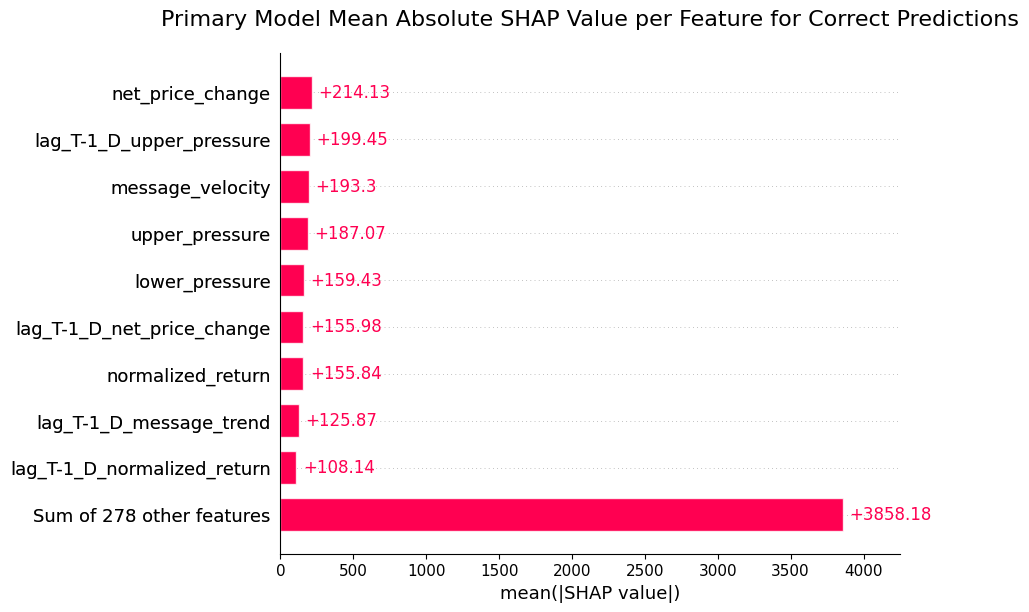


(Generating SHAP Beeswarm Plot for Correct Predictions)


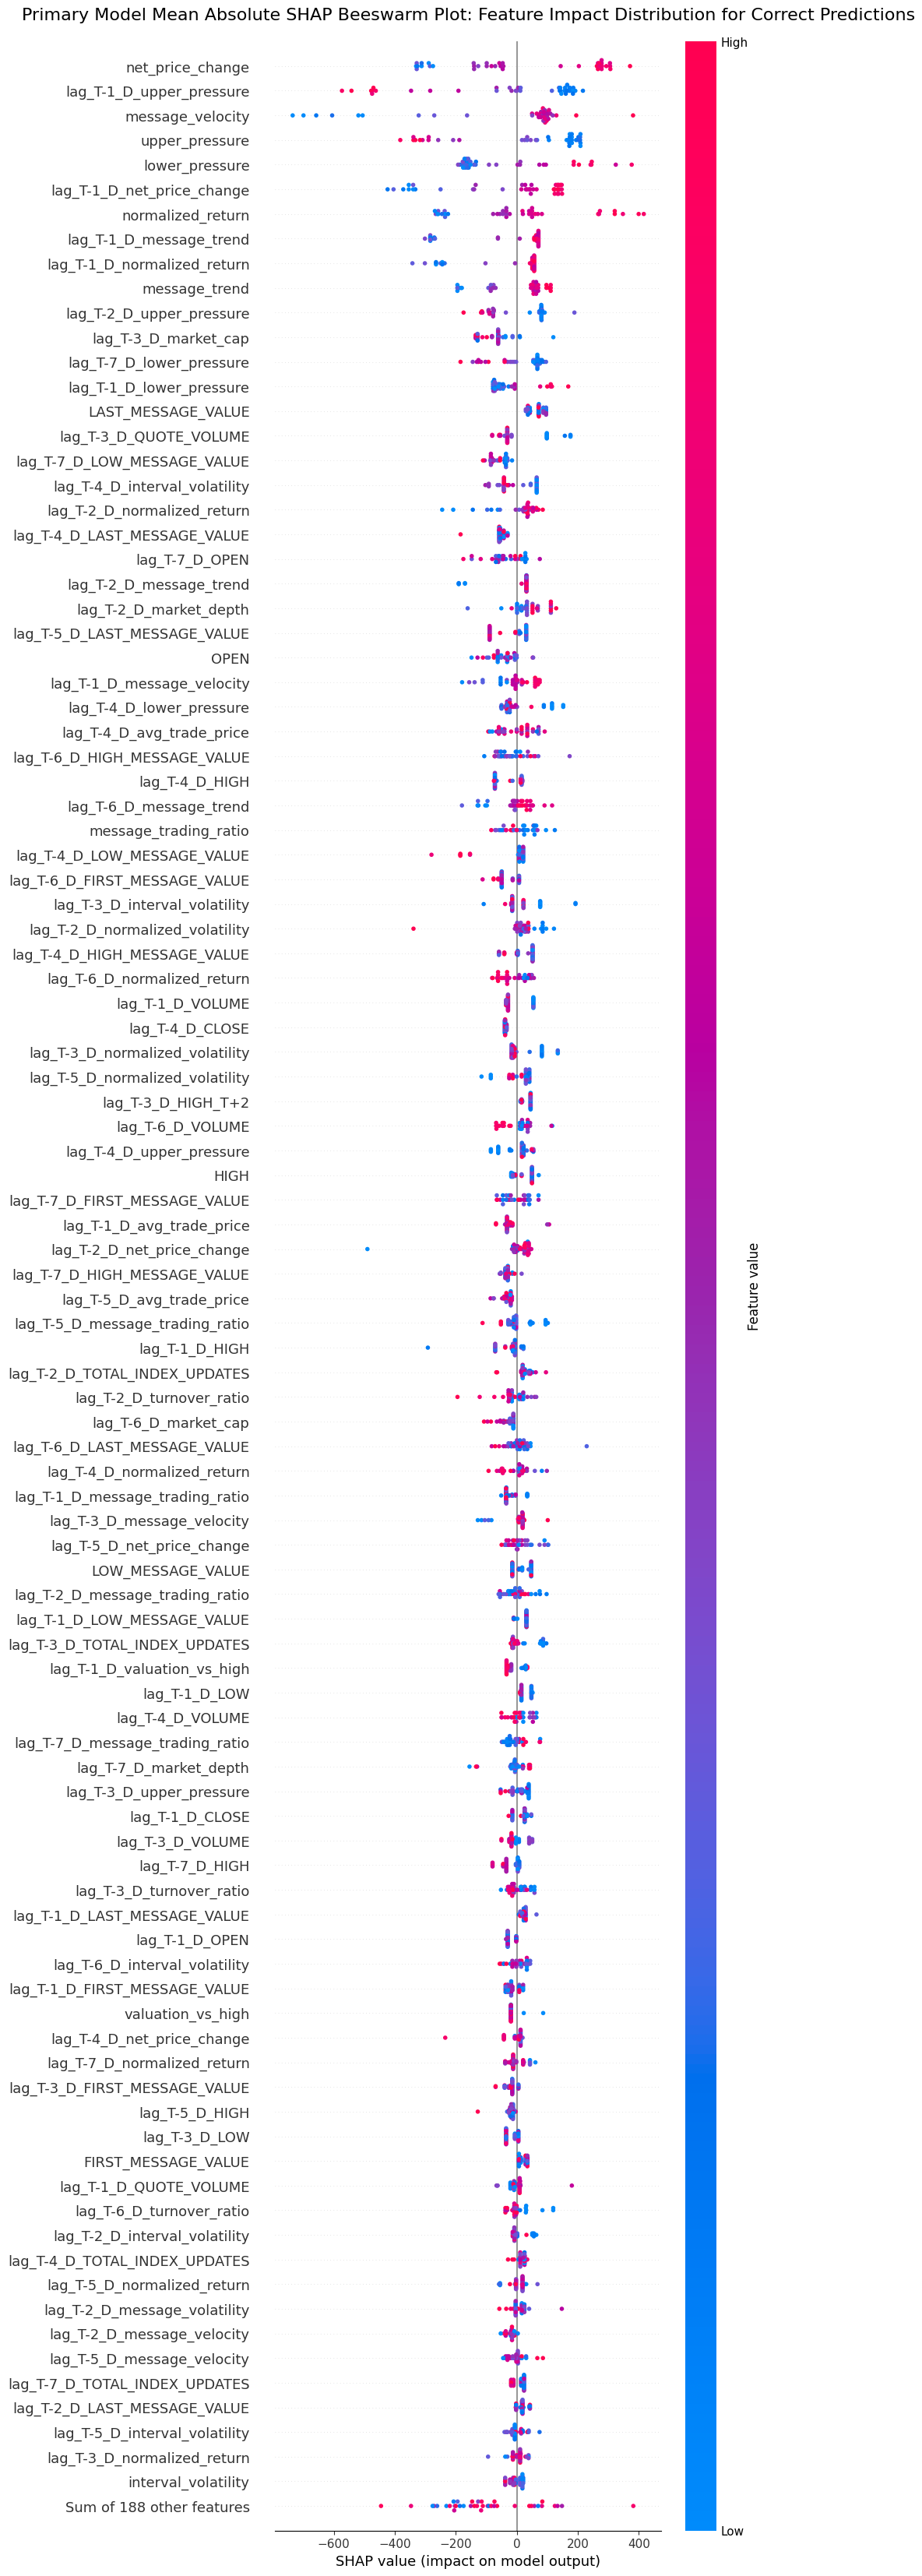

<Figure size 640x480 with 0 Axes>

In [118]:
# SHAP on correct predictions
tolerance_pct = 0.02  # within ±2% of actual value
correct_indices = np.where(np.abs((y_test.values.ravel() - test_preds) / y_test.values.ravel()) <= tolerance_pct)[0]

# Examine SHAP of correct predictions
explainer = shap.TreeExplainer(best_model) 
correct_shap_explanations = explainer(X_test_lags.iloc[correct_indices])
mean_abs_shap = np.abs(correct_shap_explanations.values).mean(axis=0)

feature_importances_correct = pd.Series(mean_abs_shap, index=X_test_lags.columns)
print("\n--- Most Influential Features for CORRECT Predictions ---")
print(feature_importances_correct.sort_values(ascending=False).head(200))

print("\n(Generating SHAP Bar Plot for Correct Predictions)")
plt.title("Primary Model Mean Absolute SHAP Value per Feature for Correct Predictions", fontsize = 16, pad = 20)
shap.plots.bar(correct_shap_explanations)
plt.tight_layout()

print("\n(Generating SHAP Beeswarm Plot for Correct Predictions)")
plt.title("Primary Model Mean Absolute SHAP Beeswarm Plot: Feature Impact Distribution for Correct Predictions", fontsize = 16, pad = 20)
shap.plots.beeswarm(correct_shap_explanations, max_display=100)
plt.tight_layout()

In [119]:
# Serialize and store model
dump(best_model,  f'models/{experiment_name}_model.joblib')

['models/36120-25SP-AT3-25400603-experiment-19_model.joblib']

#### Baseline Model Performance

In [120]:
# Baseline model of naive persistence lookback of T-2
naive_lookback = 2
naive_preds = y_test.shift(naive_lookback)
valid_idx = naive_preds.notna()

# True values (already aligned with your model’s target)
y_true = y_test[naive_lookback:target_shift]
y_pred = naive_preds[naive_lookback:target_shift]

In [121]:
# Compute metrics
mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = root_mean_squared_error(y_true, y_pred)
mape_naive = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_naive = r2_score(y_true, y_pred)

print(f"Naive baseline (lookback={target_shift}) test performance")
print(f"  MAE   : {mae_naive:.4f}")
print(f"  RMSE  : {rmse_naive:.4f}")
print(f"  MAPE% : {mape_naive:.2f}")
print(f"  R²    : {r2_naive:.4f}")

Naive baseline (lookback=-2) test performance
  MAE   : 2354.5002
  RMSE  : 3004.9147
  MAPE% : 2.05
  R²    : 0.5352


In [ ]:
# <Student to fill this section>
baseline_performance_explanations = """
We use a naïve lookback model with a two-day lag (T−2) as the baseline, selected to account for data availability constraints. Naïve lookback models represent a realistic low-resource yet high-performing benchmark that predictive models should aim to outperform.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='baseline_performance_explanations', value=baseline_performance_explanations)

#### Model Performance Summary

In [130]:
# <Student to fill this section>
model_performance_explanations = """
This model (MAE = 1951.93) outperforms the naive baseline (MAE = 2354.50) by approximately 402.57, representing a 17% improvement in predictive accuracy. The final model therefore demonstrates stronger performance in this comparison. Despite this improvement, SHAP analysis highlights that features such as normalized_return, lag_T-1_D_upper_pressure, message_velocity, lower_pressure, and lag_T-1_D_message_velocity contribute most strongly to accurate predictions. Conversely, features including FIRST_MESSAGE_VALUE and lag_T-7_D_OPEN exhibit comparatively low SHAP importance, indicating minimal contribution to model accuracy. These insights suggest that future iterations could benefit from a more selective feature inclusion strategy: excluding features with consistently low SHAP importance to reduce noise and further enhance model generalization.
"""

In [131]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance



In [124]:
# <Student to fill this section>
business_impacts_explanations = """
The impact of the model’s results on the business objective depends on the accuracy of the next-day (T + 1) HIGH price forecasts relative to the actual observed values, as well as the volume and value of trades influenced by these predictions. For Bitcoin, whose price per unit is exceptionally high, even relatively small prediction errors can translate into significant financial implications. With a mean absolute error (MAE) of approximately USD 2,000, deviations between predicted and actual HIGH prices could represent substantial potential losses for individual investors with limited capital, particularly if investment decisions are guided directly by these forecasts. Conversely, more accurate predictions could improve investor confidence, support more informed trading strategies, and increase profits. The financial impact of incorrect results is financially significant, highlighting the importance of continued model refinement and performance monitoring.
"""

In [125]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [126]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [127]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [128]:
# <Student to fill this section>
experiment_results_explanations = """
In this experiment, we train a CatBoostRegressor using a Fibonacci causal detrended target (T−2 to T−7) and a 7-day lookback window for both predictors and targets. The feature set includes engineered indicators designed to capture nuanced market dynamics under a maximum information strategy. The Fibonacci detrending method improves performance compared to raw values, log transformations, and T-2 differenced detrended transformation of the target, and the model outperforms relative to the Naive T−2 Lookback baseline. Future experiments may explore rolling or expanding window validation, feature selection refinement based on SHAP importance, different target feature transformations, and the inclusion of additional technical indicators such as RSI to further enhance model generalization.
"""

In [129]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)